# Описание Проекта: Обучение с учителем: качество модели

## Описание проекта
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 

Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

## Как решать задачу

Продумывать подход к решению этой задачи вам не придётся — руководитель отдела его уже сформировал:
Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».

Нужно собрать данные по клиентам по следующим группам:
Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.

1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

Руководство одобрило описание решения, и вам, как специалисту по DS, нужно его реализовать.

# Загрузка данных

Загрузите данные и проверьте, что данные в таблицах соответствуют описанию.

Файлы market_file.csv, market_money.csv, market_time.csv, money.csv доступны по ссылкам в описании данных или через пути к ним

In [1]:
!pip install shap
!pip install --upgrade scikit-learn
!pip install matplotlib==3.5.0 -q

     |████████████████████████████████| 539 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 13.4 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 63.1 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import numpy as np
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

In [3]:
# Загрузим исходные данные в датафреймы

try:
    market_file = pd.read_csv('market_file.csv')
    market_money = pd.read_csv('market_money.csv')
    market_time = pd.read_csv('market_time.csv')
    money = pd.read_csv('money.csv', sep=';')
except:
    market_file = pd.read_csv('/datasets/market_file.csv')
    market_money = pd.read_csv('/datasets/market_money.csv')
    market_time = pd.read_csv('/datasets/market_time.csv')
    money = pd.read_csv('/datasets/money.csv', sep=';')

# Заменим запятые на точки в столбце 'Прибыль'
money['Прибыль'] = money['Прибыль'].astype(str).str.replace(',', '.')

# Посмотрим на данные
display(market_file.head())
display(market_money.head())
display(market_time.head())
display(money.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


# Предобработка данных

Проведите необходимую предобработку данных. Названия столбцов можно оставить кириллическими.

In [4]:
# Проверим правильность типов данных
print(market_file.dtypes)
print()
print(market_money.dtypes)
print() 
print(market_time.dtypes)
print() 
print(money.dtypes)

id                                       int64
Покупательская активность               object
Тип сервиса                             object
Разрешить сообщать                      object
Маркет_актив_6_мес                     float64
Маркет_актив_тек_мес                     int64
Длительность                             int64
Акционные_покупки                      float64
Популярная_категория                    object
Средний_просмотр_категорий_за_визит      int64
Неоплаченные_продукты_штук_квартал       int64
Ошибка_сервиса                           int64
Страниц_за_визит                         int64
dtype: object

id           int64
Период      object
Выручка    float64
dtype: object

id         int64
Период    object
минут      int64
dtype: object

id          int64
Прибыль    object
dtype: object


In [5]:
# В датафрейме money заменим тип данных на float64 в столбце Прибыль
money['Прибыль'] = money['Прибыль'].astype('float64')

# Проверим правильность типов данных
print(money.dtypes)

id           int64
Прибыль    float64
dtype: object


In [6]:
# Проверим наличие пропусков
print(market_file.isna().sum())
print()
print(market_money.isna().sum())
print()
print(market_time.isna().sum())
print()
print(money.isna().sum())


id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

id         0
Период     0
Выручка    0
dtype: int64

id        0
Период    0
минут     0
dtype: int64

id         0
Прибыль    0
dtype: int64


In [7]:
# Проверим наличие явных дубликатов
print(market_file.duplicated().sum())
print()
print(market_money.duplicated().sum())
print()
print(market_time.duplicated().sum())
print()
print(money.duplicated().sum())

0

0

0

0


In [8]:
# Проверим наличие неявных дубликатов
print(market_file.nunique())
print()
print(market_money.nunique())
print()
print(market_time.nunique())
print()
print(money.nunique())


id                                     1300
Покупательская активность                 2
Тип сервиса                               3
Разрешить сообщать                        2
Маркет_актив_6_мес                       41
Маркет_актив_тек_мес                      3
Длительность                            658
Акционные_покупки                        42
Популярная_категория                      6
Средний_просмотр_категорий_за_визит       6
Неоплаченные_продукты_штук_квартал       11
Ошибка_сервиса                           10
Страниц_за_визит                         20
dtype: int64

id         1300
Период        3
Выручка    2776
dtype: int64

id        1300
Период       2
минут       20
dtype: int64

id         1300
Прибыль     400
dtype: int64


In [9]:
# Выведем уникальные значения в столбцах: "Тип сервиса", "Популярная категория", "Период"
print(market_file['Тип сервиса'].unique())
print()
print(market_file['Популярная_категория'].unique())
print()
print(market_money['Период'].unique())

['премиум' 'стандартт' 'стандарт']

['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']

['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


In [10]:
# Исправим опечатку - вместо "стандартт" в столбце "Популярная категория" заменим на "стандарт"
market_file['Популярная_категория'] = market_file['Популярная_категория'].str.replace('стандартт', 'стандарт')

# Исправим опечатку - вместо "стандартт" в столбце "Тип сервиса" заменим на "стандарт"
market_file['Тип сервиса'] = market_file['Тип сервиса'].str.replace('стандартт', 'стандарт')

# Переименуем столбцы: "Покупательская активность" в "Покупательская_активность", "Разрешить сообщать" в "Разрешить_сообщать", "Тип сервиса" в "Тип_сервиса"
market_file.rename(columns={
    'Покупательская активность': 'Покупательская_активность',
    'Разрешить сообщать': 'Разрешить_сообщать',
    'Тип сервиса': 'Тип_сервиса'
}, inplace=True)

In [11]:
# Проверим наличие выбросов в датафрейме market_file
print(market_file['Маркет_актив_6_мес'].describe())
print()
print(market_file['Длительность'].describe())
print()
print(market_file['Акционные_покупки'].describe())
print()
print(market_file['Неоплаченные_продукты_штук_квартал'].describe())
print()
print(market_file['Ошибка_сервиса'].describe())
print()
print(market_file['Страниц_за_визит'].describe())

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркет_актив_6_мес, dtype: float64

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: Длительность, dtype: float64

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: Акционные_покупки, dtype: float64

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max 

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: Выручка, dtype: float64


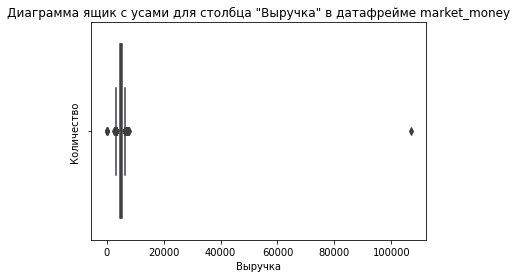

In [12]:
# Проверим наличие выбросов в датафрейме market_money
print(market_money['Выручка'].describe())

# Построим диаграмму ящик с усами для столбца "Выручка" в датафрейме market_money
sns.boxplot(data=market_money, x='Выручка')
plt.title('Диаграмма ящик с усами для столбца "Выручка" в датафрейме market_money')
plt.xlabel('Выручка')
plt.ylabel('Количество')
plt.show()

In [13]:
# Найдем id покупателя с наибольшей выручкой
print(market_money['id'].loc[market_money['Выручка'].idxmax()])


215380


In [14]:
# Сделаем срез id 215380 из датафрейма market_file
market_file_slice = market_file.loc[market_file['id'] == 215380]
display(market_file_slice)

# Сделаем срез id 215380 из датафрейма market_time
market_time_slice = market_time.loc[market_time['id'] == 215380]
display(market_time_slice)

# Сделаем срез id 215380 из датафрейма money
money_slice = money.loc[money['id'] == 215380]
display(money_slice)

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7


,id,Период,минут
64,215380,предыдцщий_месяц,12
65,215380,текущий_месяц,14


,id,Прибыль
32,215380,3.88


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


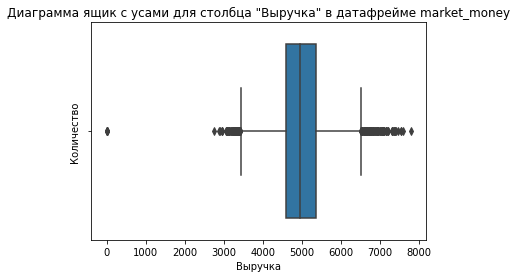

In [15]:
# Значение выручки для id 215380, вероятно, является выбросом. Заменим его на медианное значение
market_money['Выручка'].loc[market_money['id'] == 215380] = market_money['Выручка'].median()

# Построим диаграмму ящик с усами для столбца "Выручка" в датафрейме market_money
sns.boxplot(data=market_money, x='Выручка')
plt.title('Диаграмма ящик с усами для столбца "Выручка" в датафрейме market_money')
plt.xlabel('Выручка')
plt.ylabel('Количество')
plt.show()


In [16]:
# Выведем уникальные значения столбца "Период" в датафрейме market_time
print(market_time['Период'].unique())

['текущий_месяц' 'предыдцщий_месяц']


In [17]:
# Исправим опечатку в столбце "Период" в датафрейме market_time
market_time['Период'] = market_time['Период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')

In [18]:
# Проверим наличие выбросов в датафрейме money
print(money['Прибыль'].describe())

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64


В результате проделанной работы мы:

1. Проверили и скорректировали правильность типов данных;
2. Проверили наличие пропусков (отсутствуют);
3. Проверили наличие явных дубликатов (отсутствуют);
4. Проверили наличие неявных дубликатов (скорректировали);
5. Переименовали столбцы;
6. Заменили выброс на медианное значение;

# Исследовательский анализ данных

Проведите исследовательский анализ данных из каждой таблицы. Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Оформите выводы по результатам шага.

## Проведем исследовательский анализ данных для датафрейма market_file



стандарт    924
премиум     376
Name: Тип_сервиса, dtype: int64


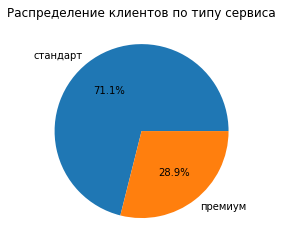

In [19]:
# Оценим распределение клиентов по типу сервиса, нарисуем круговую диаграмму
print(market_file['Тип_сервиса'].value_counts())
plt.pie(market_file['Тип_сервиса'].value_counts(), labels=market_file['Тип_сервиса'].value_counts().index, autopct='%1.1f%%')
plt.title('Распределение клиентов по типу сервиса')
plt.show()

Большинство пользователей имеют стандартную подписку.

Тип_сервиса  Разрешить_сообщать
премиум      да                    327
             нет                    49
стандарт     да                    635
             нет                   289
Name: Разрешить_сообщать, dtype: int64


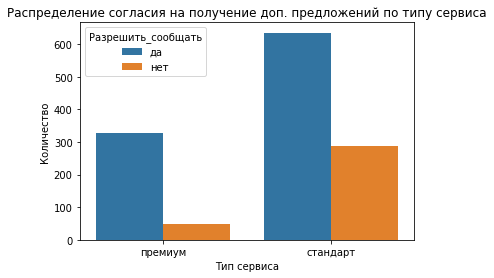

In [20]:
# Посмотрим как для разных типов сервисов распределено согласие на получение доп. предложений
print(market_file.groupby('Тип_сервиса')['Разрешить_сообщать'].value_counts())
sns.countplot(data=market_file, x='Тип_сервиса', hue='Разрешить_сообщать')
plt.title('Распределение согласия на получение доп. предложений по типу сервиса')
plt.xlabel('Тип сервиса')
plt.ylabel('Количество')
plt.show()

При этом, только 15% от премиум пользователей согласны получать рекламные сообщения, тогда как для стандартных пользователей этот показатель - около 50%.

             count        mean         std    min    25%    50%     75%  \
Тип_сервиса                                                               
премиум      376.0  722.452128  233.380097  121.0  565.5  763.0  907.25   
стандарт     924.0  552.841991  239.585270  110.0  356.0  544.0  746.25   

                max  
Тип_сервиса          
премиум      1079.0  
стандарт     1064.0  


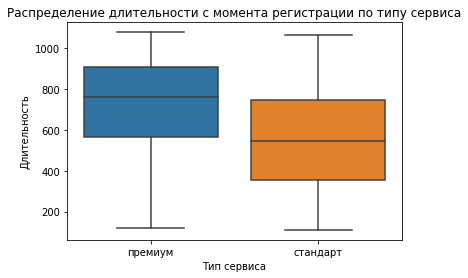

In [21]:
# Посмотрим как для разных типов сервисов распределена длительность с момента регистрации
print(market_file.groupby('Тип_сервиса')['Длительность'].describe())
sns.boxplot(data=market_file, x='Тип_сервиса', y='Длительность')
plt.title('Распределение длительности с момента регистрации по типу сервиса')
plt.xlabel('Тип сервиса')
plt.ylabel('Длительность')
plt.show()


Пользователи премиум подписки статистически дольше клиенты сервиса, чем клиенты-стандарт.

             count      mean       std  min   25%   50%   75%   max
Тип_сервиса                                                        
премиум      376.0  0.335851  0.260106  0.0  0.17  0.24  0.32  0.99
стандарт     924.0  0.313279  0.245388  0.0  0.17  0.24  0.30  0.99


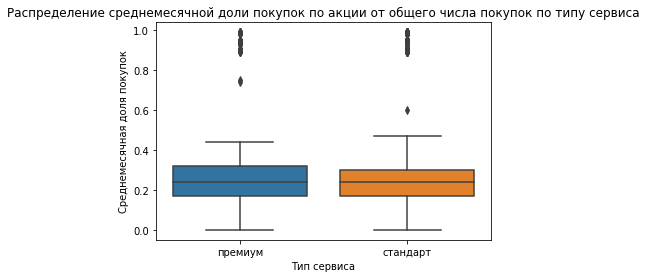

In [22]:
# Посмотрим как для разных типов сервисов распределена среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев
print(market_file.groupby('Тип_сервиса')['Акционные_покупки'].describe())
sns.boxplot(data=market_file, x='Тип_сервиса', y='Акционные_покупки')
plt.title('Распределение среднемесячной доли покупок по акции от общего числа покупок по типу сервиса')
plt.xlabel('Тип сервиса')
plt.ylabel('Среднемесячная доля покупок')
plt.show()


В обоих категория есть пользователи, совершающие покупки исключительно акционных товаров.

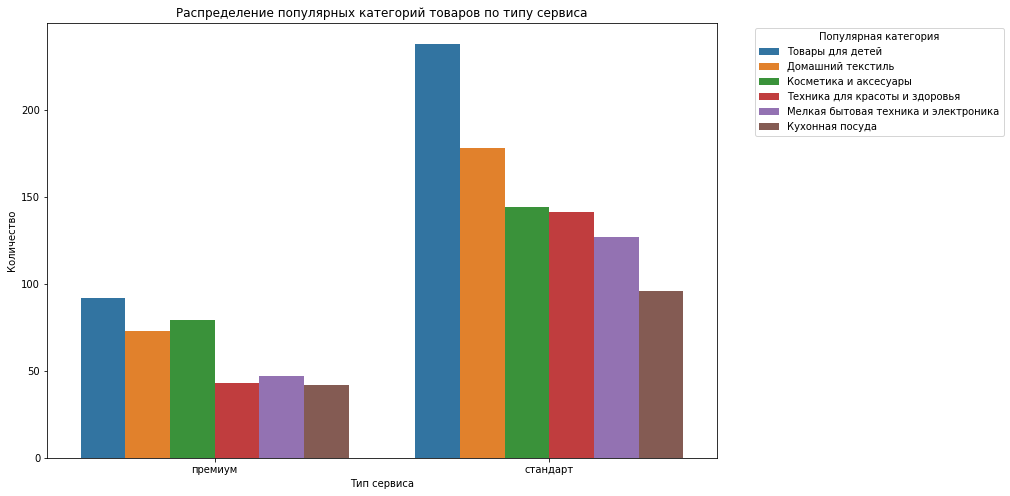

In [23]:
# Сгруппируем данные и посчитаем количество популярных категорий товаров по типам сервиса
category_counts = market_file['Популярная_категория'].value_counts()

# Отсортируем категории по убыванию
sorted_categories = category_counts.index

# Построим график
plt.figure(figsize=(12, 8))
sns.countplot(data=market_file, x='Тип_сервиса', hue='Популярная_категория', hue_order=sorted_categories)
plt.title('Распределение популярных категорий товаров по типу сервиса')
plt.xlabel('Тип сервиса')
plt.ylabel('Количество')
plt.legend(title='Популярная категория', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

В зависимости от категорий подписок, топ популярных категорий практически идентичен.

## Проведем исследовательский анализ данных для датафрейма market_money

                      count         mean         std     min      25%  \
Период                                                                  
предыдущий_месяц     1300.0  4936.059231  738.920956     0.0  4496.75   
препредыдущий_месяц  1300.0  4825.135000  405.947912     0.0  4583.00   
текущий_месяц        1300.0  5236.572615  835.188961  2758.7  4706.05   

                         50%       75%     max  
Период                                          
предыдущий_месяц     5004.50  5404.125  6869.5  
препредыдущий_месяц  4809.00  5053.500  5663.0  
текущий_месяц        5179.55  5759.275  7799.4  


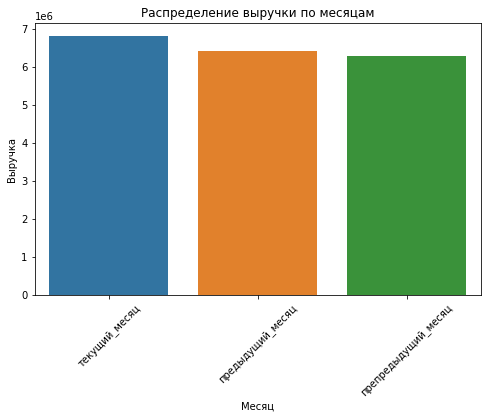

In [24]:
# Посмотрим на распределение выручки по месяцам
# Вывести статистическое описание выручки по месяцам
print(market_money.groupby('Период')['Выручка'].describe())

# Сгруппируем данные по месяцам и посчитаем сумму выручки
monthly_revenue = market_money.groupby('Период')['Выручка'].sum()

# Отсортируем значение выручки по убыванию
sorted_revenue = monthly_revenue.sort_values(ascending=False)

# Построим столбчатую диаграмму для распределения выручки по месяцам, отсортировав значения по убыванию
plt.figure(figsize=(8, 5))
sns.barplot(x=sorted_revenue.index, y=sorted_revenue.values)
plt.title('Распределение выручки по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.xticks(rotation=45)
plt.show()




Выручка растет на протяжении 3-х месяцев. 

## Проведем исследовательский анализ данных для датафрейма market_time

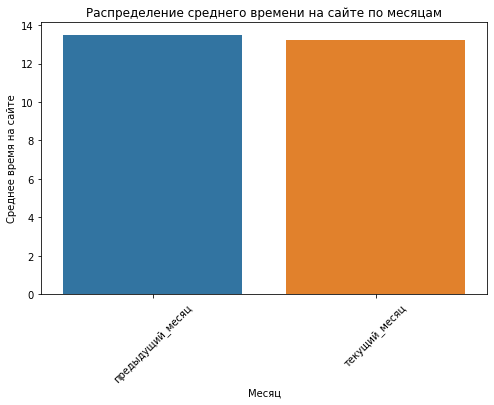

In [25]:
# Посмотрим на распределение проведенного на сайте среднего времени по месяцам

# Сгруппируем данные по месяцам и посчитаем среднее время на сайте
monthly_avg_time = market_time.groupby('Период')['минут'].mean()

# Отсортируем значение среднего времени на сайте по убыванию
sorted_avg_time = monthly_avg_time.sort_values(ascending=False)

# Построим столбчатую диаграмму для распределения среднего времени на сайте по месяцам, отсортировав значения по убыванию
plt.figure(figsize=(8, 5))
sns.barplot(x=sorted_avg_time.index, y=sorted_avg_time.values)
plt.title('Распределение среднего времени на сайте по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Среднее время на сайте')
plt.xticks(rotation=45)
plt.show()


Среднее время, проведенное на сайте клиентами практически не изменилось.

## Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период

In [26]:
# В таблице market_money отфильтруем id клиентов с выручкой равной 0
zero_revenue = market_money[market_money['id'].isin(market_money[market_money['Выручка'] == 0]['id'])]
# Выведем количество клиентов с выручкой равной 0
print('Количество строк с выручкой равной 0:', len(zero_revenue))

Количество строк с выручкой равной 0: 9


In [27]:
# Выведем список строк с выручкой равной 0
print(zero_revenue)

        id               Период  Выручка
0   215348  препредыдущий_месяц      0.0
1   215348        текущий_месяц   3293.1
2   215348     предыдущий_месяц      0.0
27  215357        текущий_месяц   5986.3
28  215357  препредыдущий_месяц      0.0
29  215357     предыдущий_месяц      0.0
33  215359        текущий_месяц   4735.0
34  215359     предыдущий_месяц      0.0
35  215359  препредыдущий_месяц      0.0


In [28]:
# Удалим строки с id = 215348, 215357 и 215359 из market_money
ids_to_remove = [215348, 215357, 215359]
market_money = market_money[~market_money['id'].isin(ids_to_remove)]

In [29]:
# Сделаем срез с клиентами, у которых выручка > 0
positive_revenue = market_money[market_money['id'].isin(market_money[market_money['Выручка'] > 0]['id'])]
# Выведем количество клиентов с выручкой больше 0
print('Количество строк с выручкой больше 0:', len(positive_revenue))

Количество строк с выручкой больше 0: 3891


## Выводы

1. Большинство пользователей имеют стандартную подписку.
2. При этом, только 15% от премиум пользователей согласны получать рекламные сообщения, тогда как для стандартных пользователей этот показатель - около 50%.
3. Пользователи премиум подписки статистически дольше клиенты сервиса, чем клиенты-стандарт.
4. В обоих категория есть пользователи, совершающие покупки исключительно акционных товаров.
5. В зависимости от категорий подписок, топ популярных категорий практически идентичен.
6. Выручка растет на протяжении 3-х месяцев.
7. Среднее время, проведенное на сайте клиентами практически не изменилось.
8. Количество клиентов с прибылью равной 0: 9. Количество клиентов с выручкой больше 0: 3900

# Объединение таблиц

Объедините таблицы market_file.csv, market_money.csv, market_time.csv. Данные о прибыли из файла money.csv при моделировании вам не понадобятся. 

Учитывайте, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. 
В итоговой таблице сделайте отдельный столбец для каждого периода.

In [30]:
# Развертывание df_money
df_money_pivot = market_money.pivot_table(index='id', columns='Период', values='Выручка', aggfunc='sum').reset_index()

# Развертывание df_time
df_time_pivot = market_time.pivot_table(index='id', columns='Период', values='минут', aggfunc='sum').reset_index()

In [31]:
# Объединим таблицы marke_file, market_money и market_time в единый датасет market_data
market_data = pd.merge(market_file, df_money_pivot, on='id')
market_data = pd.merge(market_data, df_time_pivot, on='id')

# Сбросим индексы
market_data.reset_index(drop=True, inplace=True)

# Поставим id вместо индексов
market_data.set_index('id', inplace=True)

# Выведем информацию о получившемся датасете
print(market_data.info())

# Выведем первые 5 строк датасета
display(market_data.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская_активность            1297 non-null   object 
 1   Тип_сервиса                          1297 non-null   object 
 2   Разрешить_сообщать                   1297 non-null   object 
 3   Маркет_актив_6_мес                   1297 non-null   float64
 4   Маркет_актив_тек_мес                 1297 non-null   int64  
 5   Длительность                         1297 non-null   int64  
 6   Акционные_покупки                    1297 non-null   float64
 7   Популярная_категория                 1297 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 10  Ошибка_сервиса                       1297 non-null   int64  
 11  Страниц_за_визит       

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_x,препредыдущий_месяц,текущий_месяц_x,предыдущий_месяц_y,текущий_месяц_y
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [32]:
# Переименуем столбец предыдущий_месяц_x в предыдущий_месяц_выручка
market_data = market_data.rename(columns={'предыдущий_месяц_x': 'предыдущий_месяц_выручка'})

# Переименуем столбец препредыдущий_месяц в препредыдущий_месяц_выручка
market_data = market_data.rename(columns={'препредыдущий_месяц': 'препредыдущий_месяц_выручка'})

# Переименуем столбец текущий_месяц_x в текущий_месяц_выручка
market_data = market_data.rename(columns={'текущий_месяц_x': 'текущий_месяц_выручка'})

# Переименуем столбец предыдущий_месяц_y в предыдущий_месяц_время
market_data = market_data.rename(columns={'предыдущий_месяц_y': 'предыдущий_месяц_время'})

# Переименуем столбец текущий_месяц_y в текущий_месяц_время
market_data = market_data.rename(columns={'текущий_месяц_y': 'текущий_месяц_время'})

# Выведем первые 5 строк датасета
display(market_data.head())

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_время,текущий_месяц_время
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [33]:
# Проверим наличие дубликатов
print(market_data.duplicated().sum())

# Удалим дубликаты
market_data.drop_duplicates(inplace=True)

# Проверим наличие дубликатов
print(market_data.duplicated().sum())

11
0


In [34]:
market_data.shape

(1286, 17)

# Корреляционный анализ

Проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.

In [35]:
# Сделаем список столбцов с количественными и категориальными данными (их используем в дальнейших шагах)
numeric = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 
           'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 
           'Страниц_за_визит', 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка', 'текущий_месяц_выручка', 'предыдущий_месяц_время', 'текущий_месяц_время'
          ]

categorical = ['Разрешить_сообщать', 'Популярная_категория']

,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_время,текущий_месяц_время
Маркет_актив_6_мес,1.000000,0.058089,-0.044881,-0.282402,0.187371,-0.131283,0.039146,0.322717,-0.000307,0.236113,0.006231,0.275904,0.228046
Маркет_актив_тек_мес,0.058089,1.000000,-0.132820,0.031461,-0.022429,0.063495,0.085020,0.002296,-0.022918,-0.039017,-0.006519,0.011878,-0.066205
Длительность,-0.044881,-0.132820,1.000000,0.026598,-0.043844,-0.105848,0.105002,-0.035167,0.012973,-0.039637,0.014797,-0.127521,0.085449
Акционные_покупки,-0.282402,0.031461,0.026598,1.000000,-0.208956,0.202230,-0.054356,-0.375170,0.003609,-0.272758,0.020602,-0.333432,-0.278451
Средний_просмотр_категорий_за_визит,0.187371,-0.022429,-0.043844,-0.208956,1.000000,-0.252467,0.007450,0.271035,-0.053626,0.150514,-0.075584,0.152915,0.236218
Неоплаченные_продукты_штук_квартал,-0.131283,0.063495,-0.105848,0.202230,-0.252467,1.000000,-0.099952,-0.168587,0.031015,-0.254726,0.059603,-0.186458,-0.221160
Ошибка_сервиса,0.039146,0.085020,0.105002,-0.054356,0.007450,-0.099952,1.000000,0.104916,0.035512,0.091754,0.039762,0.197071,0.074942
Страниц_за_визит,0.322717,0.002296,-0.035167,-0.375170,0.271035,-0.168587,0.104916,1.000000,-0.067325,0.314533,-0.050842,0.454532,0.301355
предыдущий_месяц_выручка,-0.000307,-0.022918,0.012973,0.003609,-0.053626,0.031015,0.035512,-0.067325,1.000000,0.305498,0.878978,-0.084575,-0.085675
препредыдущий_месяц_выручка,0.236113,-0.039017,-0.039637,-0.272758,0.150514,-0.254726,0.091754,0.314533,0.305498,1.000000,0.148597,0.352021,0.295404


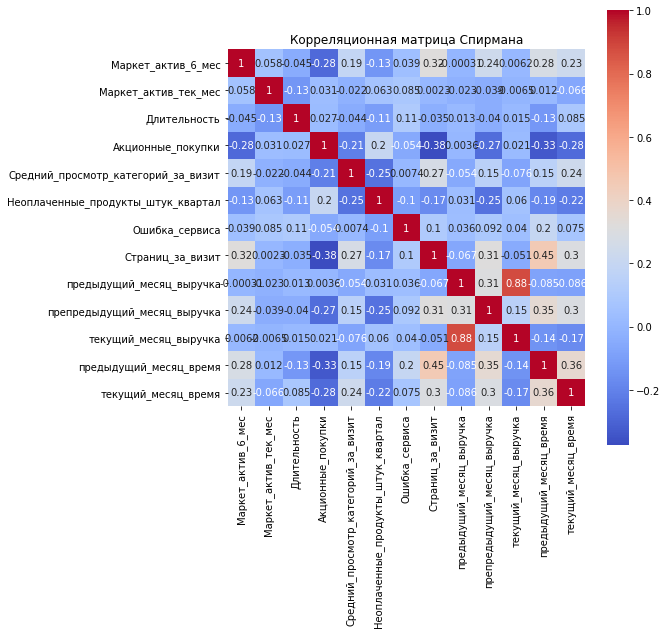

In [36]:
# Расчёт корреляционной матрицы для numeric
corr_matrix_spearman = market_data[numeric].corr(method='spearman')

# Выведем корреляционную матрицу
display(corr_matrix_spearman)
# Построение тепловой карты для корреляционной матрицы Спирмана
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix_spearman, annot=True, cmap='coolwarm', cbar=True, square=True)
plt.title('Корреляционная матрица Спирмана')
plt.show()

In [37]:
# Оценим наличие мультиколлинеарности для numeric
for col in numeric:
    for col2 in numeric:
        if col != col2:
            corr = market_data[col].corr(market_data[col2], method='spearman')
            if abs(corr) > 0.9:
                print(f'Корреляция между {col} и {col2} составляет {corr:.2f}')
                print(f'Мультиколлинеарность между {col} и {col2} выявлена')
                print()

# Подготовка данных для расчета VIF
X = market_data[numeric].copy()
X = sm.add_constant(X)  # Добавляем константу для расчета VIF

# Расчет VIF
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Оценка VIF:")
print(vif)

Оценка VIF:
                               Variable         VIF
0                                 const  353.604342
1                    Маркет_актив_6_мес    1.222922
2                  Маркет_актив_тек_мес    1.043816
3                          Длительность    1.101625
4                     Акционные_покупки    1.190825
5   Средний_просмотр_категорий_за_визит    1.181348
6    Неоплаченные_продукты_штук_квартал    1.202090
7                        Ошибка_сервиса    1.079257
8                      Страниц_за_визит    1.424514
9              предыдущий_месяц_выручка    4.256986
10          препредыдущий_месяц_выручка    1.607059
11                текущий_месяц_выручка    3.899695
12               предыдущий_месяц_время    1.536037
13                  текущий_месяц_время    1.324047


Анализ результатов

Все переменные имеют значения VIF, значительно меньше 10.
Самое высокое значение VIF, кроме константы, составляет 4.2569 (для переменной "предыдущий_месяц_выручка").
Значение VIF для константы (const) составляет 353.6, но это нормально и ожидаемо, так как константа всегда включается в модель для учета смещения.

Заключение

На основе значений VIF, представленных в вашем анализе, можно сделать следующие выводы:

1. Отсутствие значительной мультиколлинеарности: Значения VIF для всех количественных признаков находятся значительно ниже 10, что указывает на отсутствие значительных проблем с мультиколлинеарностью.

2. Нет необходимости в коррекции: Поскольку все значения VIF находятся в пределах допустимого диапазона, нет необходимости в удалении или объединении признаков для устранения мультиколлинеарности.

# Использование пайплайнов
Примените все изученные модели. Для этого используйте пайплайны.

7.1. Во время подготовки данных используйте ColumnTransformer. Количественные и категориальные признаки обработайте в пайплайне раздельно. Для кодирования категориальных признаков используйте как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.
Напоминаем, что для каждой модели можно подготовить данные с разным кодированием и масштабированием.

7.2 Обучите четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой из них подберите как минимум один гиперпараметр. Выберите подходящую для задачи метрику, аргументируйте свой выбор. Используйте эту метрику при подборе гиперпараметров.

7.3 Выберите лучшую модель, используя заданную метрику. Для этого примените одну из стратегий:

 - использовать пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно;

 - использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт вам лучшую модель.

In [38]:
# задаем константы

RANDOM_STATE = 42
TEST_SIZE = 0.25

encoder = LabelEncoder()  # создаем экземпляр LabelEncoder

# Определение переменных
X = market_data.drop('Покупательская_активность', axis=1)
y = market_data['Покупательская_активность']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

# Применение LabelEncoder на обучающей выборке
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Определение количественных и категориальных признаков
ohe_columns = categorical
ord_columns = ['Тип_сервиса']
num_columns = numeric

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error'), ohe_columns),
    ('oe', OrdinalEncoder(), ord_columns),
    ('num', StandardScaler(), num_columns)
], remainder='passthrough')

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5)
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5, 100)
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': [0.1, 1.0, 10.0, 100.0]
    },
    # словарь для модели SVC()
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__kernel': ['linear', 'rbf']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

# Выбираем лучшую модель
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# Считаем метрики на тестовой выборке
y_test_pred = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:, 1])}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['Разрешить_сообщать',
                                                   'Популярная_категория']),
                                                 ('oe', OrdinalEncoder(),
                                                  ['Тип_сервиса']),
                                                 ('num', StandardScaler(),
                                                  ['Маркет_актив_6_мес',
                                                   'Маркет_актив_тек_мес',
                                                   'Длительность',
                                                   'Акционные_покупки',
                                                   'Средний_просмотр_категорий_за_виз

# Анализ важности признаков

8.1. Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP. 

8.2. Сделайте выводы о значимости признаков:

какие признаки мало значимы для модели;

какие признаки сильнее всего влияют на целевой признак;

как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.

  0%|          | 0/322 [00:00<?, ?it/s]

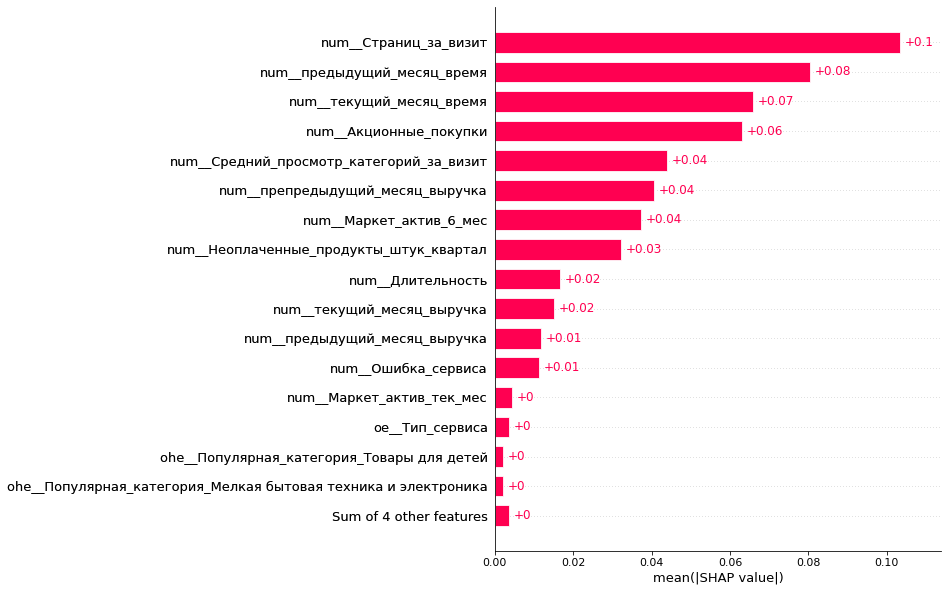

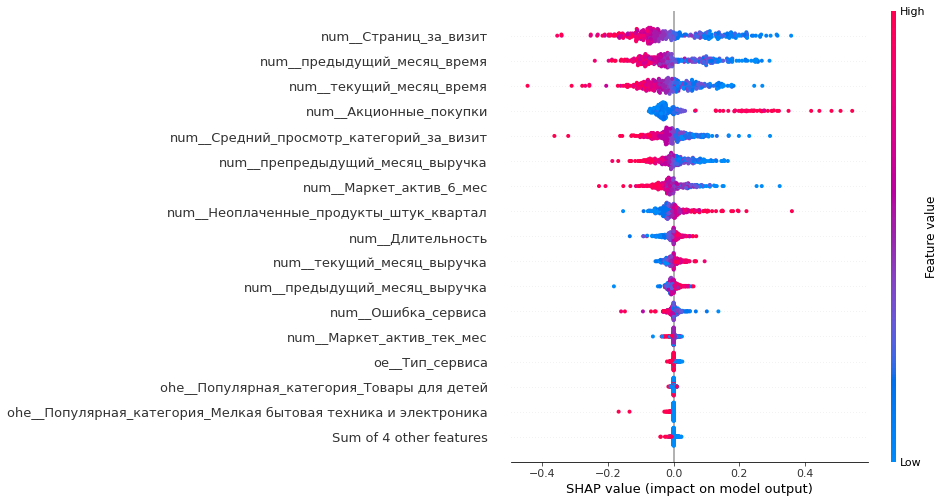

In [39]:
# Извлечение лучшей модели и предварительной обработки
best_model = randomized_search.best_estimator_.named_steps['models']
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']


X_train_preprocessed = pd.DataFrame(
    preprocessor.transform(X_train),
    columns=preprocessor.get_feature_names_out()
)

X_test_preprocessed = pd.DataFrame(
    preprocessor.transform(X_test),
    columns=preprocessor.get_feature_names_out()
)

X_train_preprocessed.head().T

background = shap.kmeans(X_train_preprocessed, 10)

# Создание объекта Explainer для модели SVC
explainer = shap.KernelExplainer(best_model.predict, background)

# Вычисление значений SHAP для тестовых данных
shap_values = explainer(X_test_preprocessed)

# Построение графика - общий вклад признаков в прогнозы модели
shap.plots.bar(shap_values, max_display=17)

shap.plots.beeswarm(shap_values, max_display=17)

## Какие признаки мало значимы для модели:

 - Популярные категории;
 - Тип сервиса;
 - Маркетинговая активность в текущем месяце;
 - Ошибки сервиса;
 - Выручка в текущем и предыдущем месяцах;
 - Длительность.

## Какие признаки сильнее всего влияют на целевой признак:

 - Кол-во страниц интернет-магазина, просмотренное пользователем;
 - Высокая доля покупок по акциям;
 - Время, проведенное на сайте в текущем и предыдущем месяцах;
 - Кол-во категорий, просмотренное пользователем;

## Как можно использовать эти наблюдения при моделировании и принятии бизнес-решений:

    1. Необходимо удерживать покупателей, потративших больше времени и просмотревших больше страниц ресурса, чем в среднем.
    2. Необходимо удерживать покупателей, которые совершают больше покупок по акциям.
    3. Необходимо удерживать покупателей, которые смотрят больше категорий.
    

# Сегментация покупателей

9.1. Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.

9.2. Выберите группу покупателей и предложите, как увеличить её покупательскую активность: 

    - Проведите графическое и аналитическое исследование группы покупателей.
    - Сделайте предложения по работе с сегментом для увеличения покупательской активности.
    
9.3. Сделайте выводы о сегментах:

    - какой сегмент вы взяли для дополнительного исследования,
    - какие предложения вы сделали и почему.

In [40]:
threshold = 0.9

# Применим модель для всех данных
best_model = randomized_search.best_estimator_
predictions = best_model.predict_proba(X)[:, 1]
prediction_flags = np.where(predictions > threshold, True, False)

In [41]:
# Выберем только те данные для которых модель предсказала снижение
df_decline = market_data.loc[prediction_flags]

# Добавим в эти данные прибыльность из таблицы money
df_decline = df_decline.join(money.set_index('id'), on='id', how='left')

# Проверим что появился столбец
df_decline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210 entries, 215349 to 215910
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская_активность            210 non-null    object 
 1   Тип_сервиса                          210 non-null    object 
 2   Разрешить_сообщать                   210 non-null    object 
 3   Маркет_актив_6_мес                   210 non-null    float64
 4   Маркет_актив_тек_мес                 210 non-null    int64  
 5   Длительность                         210 non-null    int64  
 6   Акционные_покупки                    210 non-null    float64
 7   Популярная_категория                 210 non-null    object 
 8   Средний_просмотр_категорий_за_визит  210 non-null    int64  
 9   Неоплаченные_продукты_штук_квартал   210 non-null    int64  
 10  Ошибка_сервиса                       210 non-null    int64  
 11  Страниц_за_визит        

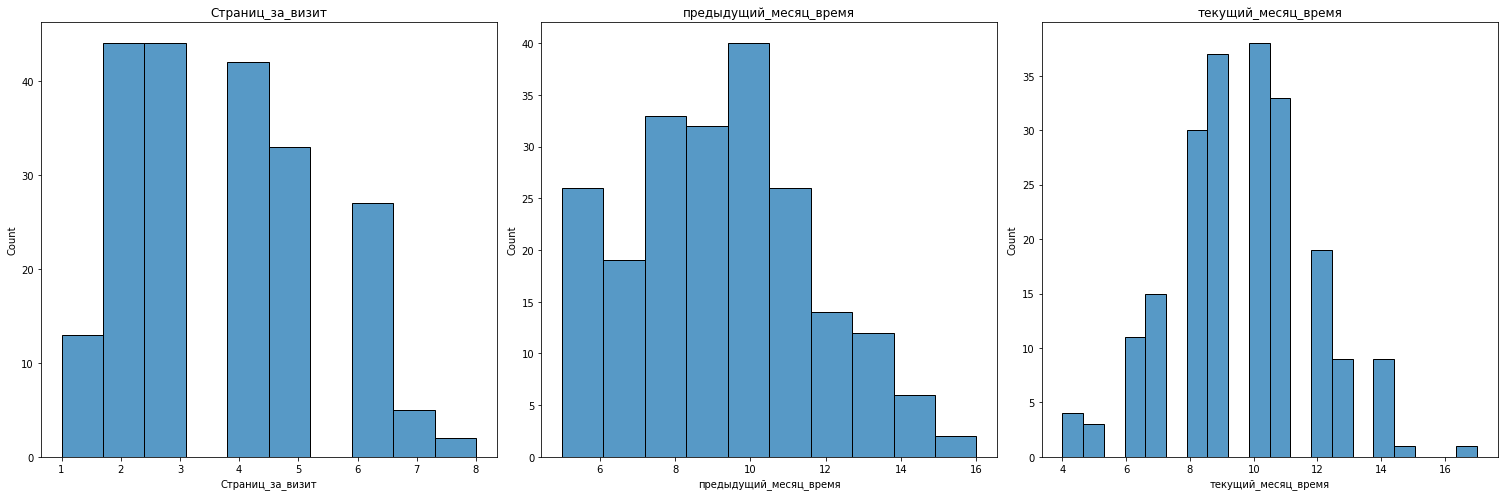

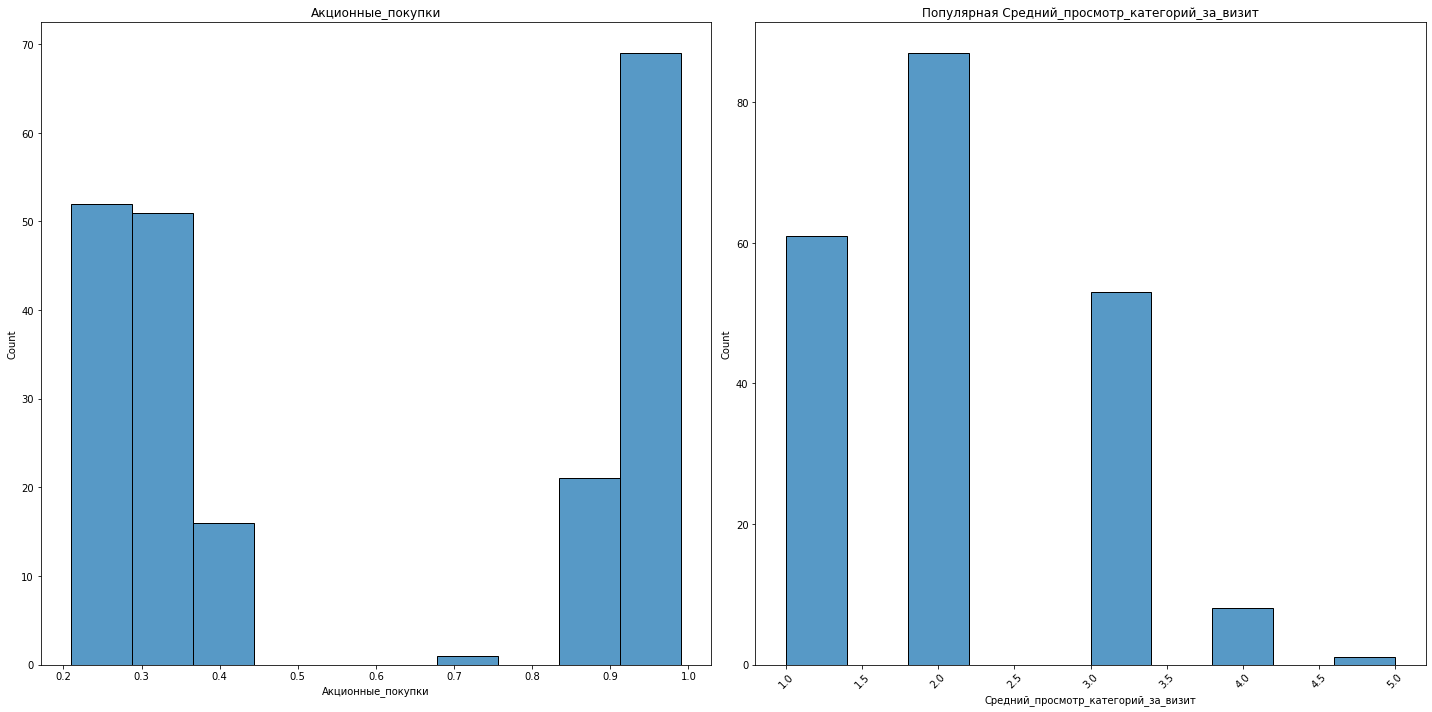

In [42]:
# У нас есть список параметров которые влияют на снижение покупательской активности. 
# Возьмем первые 5 и выделим группу на основе них
# Страниц_за_визит, предыдущий_месяц_время, текущий_месяц_время, Акционные_покупки, Средний_просмотр_категорий_за_визит

plt.figure(figsize=(21, 7))

plt.subplot(1, 3, 1)
sns.histplot(df_decline['Страниц_за_визит'], bins=10)
plt.title('Страниц_за_визит')

plt.subplot(1, 3, 2)
sns.histplot(df_decline['предыдущий_месяц_время'], bins=10)
plt.title('предыдущий_месяц_время')

plt.subplot(1, 3, 3)
sns.histplot(df_decline['текущий_месяц_время'], bins=20)
plt.title('текущий_месяц_время')

plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.histplot(df_decline['Акционные_покупки'], bins=10)
plt.title('Акционные_покупки')

plt.subplot(1, 2, 2)
sns.histplot(df_decline['Средний_просмотр_категорий_за_визит'], bins=10)
plt.title('Популярная Средний_просмотр_категорий_за_визит')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Промежуточные Выводы

Для сегментации мы взяли группу клиентов, для которых модель предсказала снижение покупательской активности. 

Для того, чтобы увеличить покупательскую активность данной группы, необходимо:

 1. Стимулировать число просмотренных страниц, а также время, проведенное на сайте, т.к. данные параметры ниже, чем их нормальное распределение.
 2. Проводить больше акций для данной группы клиентов, т.к. существенное кол-во данных клиентов имеют статистику покупки акционных товаров существенно ниже среднего.

# Общие выводы

В результате проделанной работы мы:

 1. Получили исходные данные в виде 4-х датасетов.
 
 
 2. Провели предобработку данных. 
 
     2.1. Проверили и скорректировали правильность типов данных;
 
     2.2. Проверили наличие пропусков (отсутствуют);
     
     2.3. Проверили наличие явных дубликатов (отсутствуют);
     
     2.4. Проверили наличие неявных дубликатов (скорректировали);
     
     2.5. Переименовали столбцы;
     
     2.6. Заменили выброс на медианное значение;
     
 3. Провели исследовательский анализ данных.
 
    3.1. Большинство пользователей имеют стандартную подписку.
    
    3.2. При этом, только 15% от премиум пользователей согласны получать рекламные сообщения, тогда как для стандартных пользователей этот показатель - около 50%.
    
    3.3. Пользователи премиум подписки статистически дольше клиенты сервиса, чем клиенты-стандарт.
    
    3.4. В обоих категория есть пользователи, совершающие покупки исключительно акционных товаров.
    
    3.5. В зависимости от категорий подписок, топ популярных категорий практически идентичен.
    
    3.6. Выручка растет на протяжении 3-х месяцев.
    
    3.7. Среднее время, проведенное на сайте клиентами практически не изменилось.
    
    3.8. Количество клиентов с прибылью равной 0: 9. Количество клиентов с выручкой больше 0: 3900
    
    
 4. Объединили данные в один датасет.
 
 
 5. Провели корреляционный анализ.
 
    5.1. Отсутствие значительной мультиколлинеарности: Значения VIF для всех количественных признаков находятся значительно ниже 10, что указывает на отсутствие значительных проблем с мультиколлинеарностью.

    5.2. Нет необходимости в коррекции: Поскольку все значения VIF находятся в пределах допустимого диапазона, нет необходимости в удалении или объединении признаков для устранения мультиколлинеарности.
    
    
 6. С помощью пайплайнов и метрик определили наилучшую модель предсказания целевого признака, обучили ее и использовали.
 
    6.1. Во время подготовки данных использовали ColumnTransformer. Количественные и категориальные признаки обработали в пайплайне раздельно. Для кодирования категориальных признаков использовали как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера. 

    6.2. Обучили четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). Для каждой из них подобрали как минимум один гиперпараметр. Выбрали подходящую для задачи метрику Roc-Auc.

    6.3. Выбарите лучшую модель, используя заданную метрику. Это оказалась модель KNN.
  
  
 7. Оценили значимость признаков.
 
     7.1. Какие признаки мало значимы для модели:

 - Популярные категории;
 - Тип сервиса;
 - Маркетинговая активность в текущем месяце;
 - Ошибки сервиса;
 - Выручка в текущем и предыдущем месяцах;
 - Длительность.

    7.2. Какие признаки сильнее всего влияют на целевой признак:

 - Кол-во страниц интернет-магазина, просмотренное пользователем;
 - Высокая доля покупок по акциям;
 - Время, проведенное на сайте в текущем и предыдущем месяцах;
 - Кол-во категорий, просмотренное пользователем;

    7.3. Как можно использовать эти наблюдения при моделировании и принятии бизнес-решений:

    1. Необходимо удерживать покупателей, потративших больше времени и просмотревших больше страниц ресурса, чем в среднем.
    2. Необходимо удерживать покупателей, которые совершают больше покупок по акциям.
    3. Необходимо удерживать покупателей, которые смотрят больше категорий.

8. Для сегментации мы взяли группу клиентов, для которых модель предсказала снижение покупательской активности. 

Для того, чтобы увеличить покупательскую активность данной группы, необходимо:

 1. Стимулировать число просмотренных страниц, а также время, проведенное на сайте, т.к. данные параметры ниже, чем их нормальное распределение.
 2. Проводить больше акций для данной группы клиентов, т.к. существенное кол-во данных клиентов имеют статистику покупки акционных товаров существенно ниже среднего.